# Import Libraries

In [ ]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [ ]:
!pip install albumentations

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise.


In [ ]:
from PIL import Image
import numpy as np

class AlbumentationsWrapper(object):
       def __init__(self, albumentation):
           self.albumentation = albumentation

       def __call__(self, img):
           # Assuming you're working with PIL images
           img = np.array(img)  # Convert PIL image to NumPy array
           augmented = self.albumentation(image=img)
           return Image.fromarray(augmented['image'])  # Convert back to PIL image

In [ ]:
import albumentations

# Train Phase transformations
train_transforms = transforms.Compose([
                                       transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       AlbumentationsWrapper(albumentations.CoarseDropout(max_holes=1, max_height=6, max_width=6, min_holes=1, min_height=4, min_width=4, fill_value=1, mask_fill_value=None, always_apply=False, p=0.25)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values.
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.24 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


# Dataset and Creating Train/Test Split

In [ ]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 18.4MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 493kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.42MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 4.26MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



# Dataloader Arguments & Test/Train Dataloaders


In [ ]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


# Data Statistics


torch.Size([128, 1, 28, 28])
torch.Size([128])


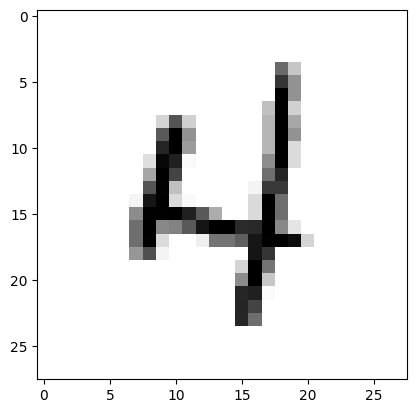

In [ ]:
dataiter = iter(train_loader)
images, labels = next(dataiter)

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')


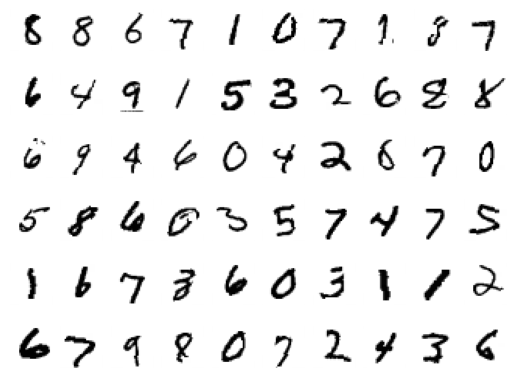

In [ ]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

## Model

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MNISTNet(nn.Module):
    def __init__(self):
        super(MNISTNet, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 8, 3, padding=0, bias=0)
        self.bnorm1 = nn.BatchNorm2d(8)
        # 28 -> 26 x 26 x 8 | RF - 3

        self.conv2 = nn.Conv2d(8, 16, 3, padding=0, bias=0)
        self.bnorm2 = nn.BatchNorm2d(16)
        # 26 -> 24 x 24 x 16 | RF - 5

        self.pool1 = nn.MaxPool2d(2, 2)
        # 24 -> 12 x 12 x 16 | RF - 6

        self.noconv1 = nn.Conv2d(16, 8, 1)
        # 12 -> 12 x 12 x 10 | RF - 6

        self.conv3 = nn.Conv2d(8, 12, 3, padding=0, bias=0)
        self.bnorm3 = nn.BatchNorm2d(12)
        # 12 -> 10 x 10 x 16 | RF - 10

        self.conv4 = nn.Conv2d(12, 12, 3, padding=0, bias=0)
        self.bnorm4 = nn.BatchNorm2d(12)
        # 10 -> 8 x 8 x 16 | RF - 14

        self.conv5 = nn.Conv2d(12, 16, 3, padding=0, bias=0)
        self.bnorm5 = nn.BatchNorm2d(16)
        # 8 -> 6 x 6 x 16 | RF - 18

        self.conv6 = nn.Conv2d(16, 16, 3, padding=0, bias=0)
        self.bnorm6 = nn.BatchNorm2d(16)
        # 8 -> 4 x 4 x 16 | RF - 22

        self.gap = nn.AdaptiveAvgPool2d((1, 1))
        # 4 x 4 x 16 -> 1 x 1 x 16 | RF - 28

        self.noconv2 = nn.Conv2d(16, 10, 1, bias=0)
        # 1 x 1 x 16 -> 1 x 1 x 10 | RF - 28

        self.drop = nn.Dropout2d(0.01)


    def forward(self, x):
        # Convolutional layers with ReLU and pooling
        x = F.relu(self.conv1(x))
        x = self.bnorm1(x)
        x = self.drop(x)

        x = F.relu(self.conv2(x))
        x = self.bnorm2(x)
        x = self.drop(x)

        x = self.pool1(x)

        x = self.noconv1(x)

        x = F.relu(self.conv3(x))
        x = self.bnorm3(x)
        x = self.drop(x)

        x = F.relu(self.conv4(x))
        x = self.bnorm4(x)
        x = self.drop(x)

        x = F.relu(self.conv5(x))
        x = self.bnorm5(x)
        x = self.drop(x)

        x = F.relu(self.conv6(x))
        x = self.bnorm6(x)
        x = self.drop(x)

        x = self.gap(x)

        x = self.noconv2(x)

        x = x.view(-1, 10)

        # Log softmax for the output
        return F.log_softmax(x, dim=1)

## Model Params

In [ ]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = MNISTNet().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
       BatchNorm2d-2            [-1, 8, 26, 26]              16
         Dropout2d-3            [-1, 8, 26, 26]               0
            Conv2d-4           [-1, 16, 24, 24]           1,152
       BatchNorm2d-5           [-1, 16, 24, 24]              32
         Dropout2d-6           [-1, 16, 24, 24]               0
         MaxPool2d-7           [-1, 16, 12, 12]               0
            Conv2d-8            [-1, 8, 12, 12]             136
            Conv2d-9           [-1, 12, 10, 10]             864
      BatchNorm2d-10           [-1, 12, 10, 10]              24
        Dropout2d-11           [-1, 12, 10, 10]               0
           Conv2d-12             [-1, 12, 8, 8]           1,296
      BatchNorm2d-13             [-1, 12, 8, 8]              24
        Dropout2d-14             [

## Training and Testing

In [ ]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

## Let's Train and test our model

In [ ]:
model =  MNISTNet().to(device)

# adam optimizer
optimizer = optim.Adam(model.parameters(), lr=0.01)

# learning rate scheduler
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=6, gamma=0.1)


EPOCHS = 15
for epoch in range(1, EPOCHS + 1):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)
    lr_scheduler.step()
    print("Learning rate: ", optimizer.state_dict()['param_groups'][0]['lr'])


EPOCH: 1


Loss=0.0963362380862236 Batch_id=468 Accuracy=94.58: 100%|██████████| 469/469 [00:41<00:00, 11.26it/s]



Test set: Average loss: 0.0436, Accuracy: 9863/10000 (98.63%)

Learning rate:  0.01
EPOCH: 2


Loss=0.03392719849944115 Batch_id=468 Accuracy=97.55: 100%|██████████| 469/469 [00:33<00:00, 14.11it/s]



Test set: Average loss: 0.0342, Accuracy: 9905/10000 (99.05%)

Learning rate:  0.01
EPOCH: 3


Loss=0.04722735285758972 Batch_id=468 Accuracy=98.06: 100%|██████████| 469/469 [00:33<00:00, 14.10it/s]



Test set: Average loss: 0.0316, Accuracy: 9903/10000 (99.03%)

Learning rate:  0.01
EPOCH: 4


Loss=0.044192757457494736 Batch_id=468 Accuracy=98.22: 100%|██████████| 469/469 [00:35<00:00, 13.30it/s]



Test set: Average loss: 0.0294, Accuracy: 9899/10000 (98.99%)

Learning rate:  0.01
EPOCH: 5


Loss=0.05868487432599068 Batch_id=468 Accuracy=98.34: 100%|██████████| 469/469 [00:32<00:00, 14.30it/s]



Test set: Average loss: 0.0300, Accuracy: 9899/10000 (98.99%)

Learning rate:  0.01
EPOCH: 6


Loss=0.12007396668195724 Batch_id=468 Accuracy=98.41: 100%|██████████| 469/469 [00:31<00:00, 14.71it/s]



Test set: Average loss: 0.0285, Accuracy: 9912/10000 (99.12%)

Learning rate:  0.001
EPOCH: 7


Loss=0.0034501429181545973 Batch_id=468 Accuracy=98.88: 100%|██████████| 469/469 [00:32<00:00, 14.35it/s]



Test set: Average loss: 0.0166, Accuracy: 9946/10000 (99.46%)

Learning rate:  0.001
EPOCH: 8


Loss=0.06225895881652832 Batch_id=468 Accuracy=99.01: 100%|██████████| 469/469 [00:31<00:00, 14.81it/s]



Test set: Average loss: 0.0164, Accuracy: 9950/10000 (99.50%)

Learning rate:  0.001
EPOCH: 9


Loss=0.03966546803712845 Batch_id=468 Accuracy=99.06: 100%|██████████| 469/469 [00:31<00:00, 14.92it/s]



Test set: Average loss: 0.0166, Accuracy: 9943/10000 (99.43%)

Learning rate:  0.001
EPOCH: 10


Loss=0.03700659051537514 Batch_id=468 Accuracy=99.03: 100%|██████████| 469/469 [00:31<00:00, 14.73it/s]



Test set: Average loss: 0.0159, Accuracy: 9949/10000 (99.49%)

Learning rate:  0.001
EPOCH: 11


Loss=0.02401338331401348 Batch_id=468 Accuracy=99.05: 100%|██████████| 469/469 [00:31<00:00, 14.67it/s]



Test set: Average loss: 0.0160, Accuracy: 9948/10000 (99.48%)

Learning rate:  0.001
EPOCH: 12


Loss=0.09338372200727463 Batch_id=468 Accuracy=99.07: 100%|██████████| 469/469 [00:31<00:00, 14.74it/s]



Test set: Average loss: 0.0158, Accuracy: 9946/10000 (99.46%)

Learning rate:  0.0001
EPOCH: 13


Loss=0.008355892263352871 Batch_id=468 Accuracy=99.10: 100%|██████████| 469/469 [00:31<00:00, 14.76it/s]



Test set: Average loss: 0.0151, Accuracy: 9946/10000 (99.46%)

Learning rate:  0.0001
EPOCH: 14


Loss=0.009064729325473309 Batch_id=468 Accuracy=99.14: 100%|██████████| 469/469 [00:32<00:00, 14.31it/s]



Test set: Average loss: 0.0150, Accuracy: 9948/10000 (99.48%)

Learning rate:  0.0001
EPOCH: 15


Loss=0.006398373749107122 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:31<00:00, 14.70it/s]



Test set: Average loss: 0.0151, Accuracy: 9946/10000 (99.46%)

Learning rate:  0.0001


In [ ]:

%matplotlib inline
import matplotlib.pyplot as plt

def plot_training_curve(train_losses, train_acc, test_losses, test_acc):
    t = [t_items.item() for t_items in train_losses]
    fig, axs = plt.subplots(2,2,figsize=(15,10))
    axs[0, 0].plot(t)
    axs[0, 0].set_title("Training Loss")
    axs[1, 0].plot(train_acc[4000:])
    axs[1, 0].set_title("Training Accuracy")
    axs[0, 1].plot(test_losses)
    axs[0, 1].set_title("Test Loss")
    axs[1, 1].plot(test_acc)
    axs[1, 1].set_title("Test Accuracy")

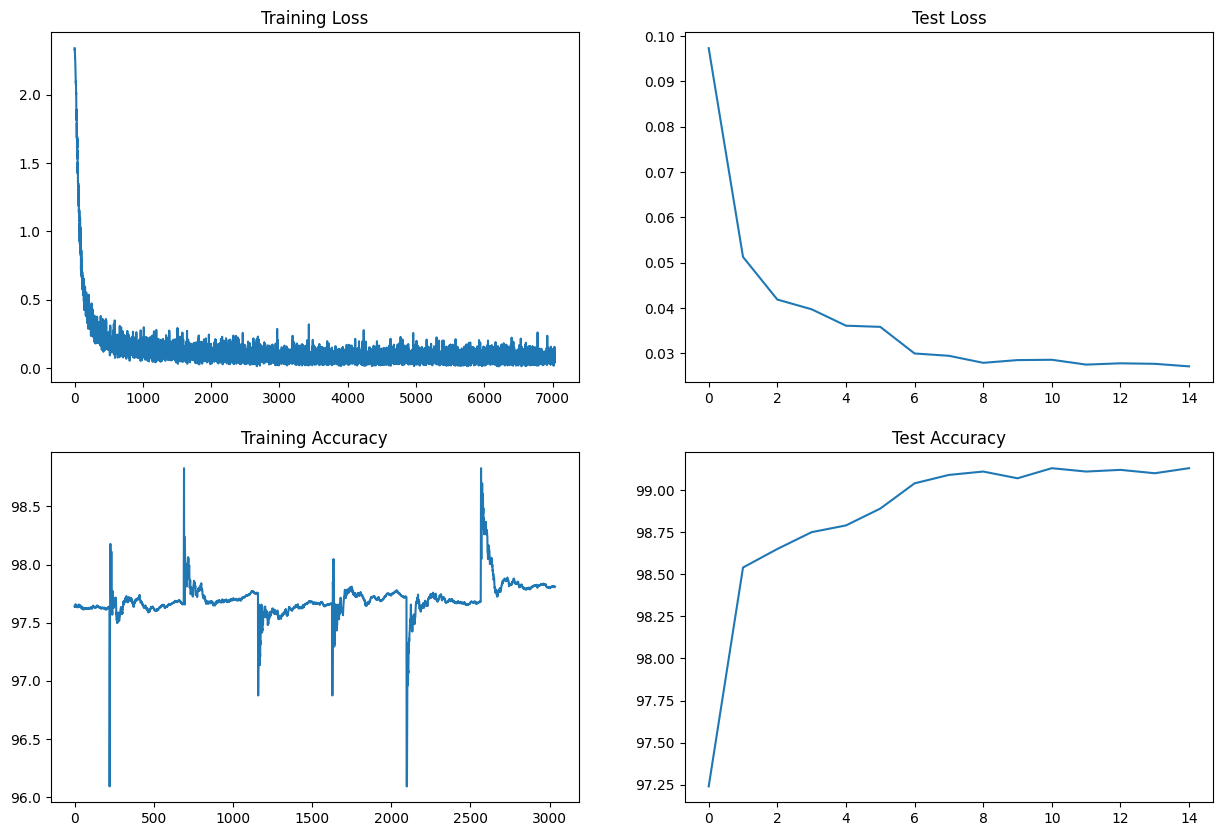

In [ ]:
plot_training_curve(train_losses, train_acc, test_losses, test_acc)

## Target, Results and Analysis

### Target
- Add more data augmentation (Cutout)
- Modify Architecture and increase some capacity within 8000 parameters.
- Adding dropout to all the layers
- Implement StepLR for updating learning rate for faster convergence.
- Switch to Adam optimiser to make the network adapt for individual weights.  

  
### Result

Model Parameters:  7,872  
Best Train Accuracy: 99.23  
Best Test Accuracy: 99.50 (8th epoch)
  
### Analysis
- Achieved 99.5% accuracy in 8th epoch and consistently more than 99.4% in 15 epochs.
- Achieved faster convergence with Data Augmentation and StepLR (Accuracy in 2nd epoch itself is more than 99%)
- Model is neither under-fitting or over-fitting. Started with under-fitting because of Augmentation, and picked up to more than 99% training accuracy.
